In [15]:
# -*- coding: utf-8 -*-
"""
@author: 代码医生工作室
@公众号：xiangyuejiqiren   （内有更多优秀文章及学习资料）
@来源: <PyTorch深度学习和图神经网络（卷 1）——基础知识>配套代码
@配套代码技术支持：bbs.aianaconda.com
Created on Sat Oct 19 20:03:44 2019
"""

from pathlib import Path  # 提升路径的兼容性
# 引入矩阵运算相关库
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags, eye

# 引入深度学习框架库
import torch
from torch import nn
import torch.nn.functional as F
# 引入绘图库
import matplotlib.pyplot as plt

# conda install pandas


from ranger import *

from tqdm import tqdm  # pip install tqdm


In [16]:

# 输出运算资源请况
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# 输出样本路径
path = Path('../data/cora')
print(path)

# 读取论文内容数据，并将其转化为数组
paper_features_label = np.genfromtxt(path / 'cora.content', dtype=np.str)
print(paper_features_label, np.shape(paper_features_label))

# 取出数据的第一列：论文的ID
papers = paper_features_label[:, 0].astype(np.int32)
print(papers)
# 为论文重新编号，{31336: 0, 1061127: 1,……
paper2idx = {k: v for v, k in enumerate(papers)}

# 将数据中间部分的字标签取出，转化成矩阵
features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
print(np.shape(features))

# 将最后一项的论文分类属性取出，并转化为分类索引
labels = paper_features_label[:, -1]
lbl2idx = {k: v for v, k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
print(lbl2idx, labels[:5])

# 读取论文关系数据，并将其转化为数组
edges = np.genfromtxt(path / 'cora.cites', dtype=np.int32)
print(edges, np.shape(edges))
# 转化为新编号节点间的关系
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
print(edges, edges.shape)

# 计算邻接矩阵（Adjacency matrix） ，行列都为论文个数
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)

# Symmetric adjacency matrix
# adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
# 生成无向图对称矩阵
adj_long = adj.multiply(adj.T < adj)
adj = adj_long + adj_long.T


##############################

cpu
..\data\cora


C:\Users\11420\AppData\Local\Temp\ipykernel_10172\4242117897.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paper_features_label = np.genfromtxt(path / 'cora.content', dtype=np.str)


[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']] (2708, 1435)
[  31336 1061127 1106406 ... 1128978  117328   24043]
(2708, 1433)
{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6} [2, 5, 4, 4, 3]
[[     35    1033]
 [     35  103482]
 [     35  103515]
 ...
 [ 853118 1140289]
 [ 853155  853118]
 [ 954315 1155073]] (5429, 2)
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]] (5429, 2)


In [17]:

def normalize(mx):  # 定义函数，对矩阵数据进行归一化
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))  # 每一篇论文的字数
    r_inv = (rowsum ** -1).flatten()  # 取总字数的倒数
    r_inv[np.isinf(r_inv)] = 0.  # 将Nan值设为0
    r_mat_inv = diags(r_inv)  # 将总字数的倒数做成对角矩阵
    mx = r_mat_inv.dot(mx)  # 左乘一个矩阵，相当于每个元素除以总数 随机归一化
    return mx




def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -0.5).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    return mx.dot(r_mat_inv).transpose().dot(r_mat_inv) # 对称归一化



# 对 features矩阵进行归一化（每行的总和为1）
features = normalize(features)

# 对邻接矩阵对角线添加1，将其变为自循环图。同时再对其进行归一化
# adj = normalize(adj + eye(adj.shape[0]))
adj = normalize_adj(adj + eye(adj.shape[0]))
################################################



In [18]:

# Data as tensors
adj = torch.FloatTensor(adj.todense())  # 节点间的关系
features = torch.FloatTensor(features.todense())  # 节点自身的特征
labels = torch.LongTensor(labels)  # 每个节点的分类标签

# 划分数据集
n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
np.random.seed(34)
idxs = np.random.permutation(len(features))  # 将原有索引打乱顺序
# 计算每个数据集的索引
idx_train = torch.LongTensor(idxs[:n_train])
idx_val = torch.LongTensor(idxs[n_train:n_train + n_val])
idx_test = torch.LongTensor(idxs[n_train + n_val:])

# 分配运算资源
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)


In [19]:


def mish(x):  # Mish激活函数
    return x * (torch.tanh(F.softplus(x)))


class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout=0.6):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        # (in_f, out_f)
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W)
        # (2*f_out, 1)
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a)

    def forward(self, input, adj):
        # n = batch_size
        # (n, out_f) = (n, in_f) @ (in_f, out_f)
        h = torch.mm(input, self.W)
        # N = n
        N = h.size()[0]
        # 特征维度：h.repeat(1, N).view(N * N, -1)。 (n*1, out_f*N) = (N, out_f*N) --view-> (N*N, out_f)
        # 批次维度：h.repeat(N, 1)。 (n*N, out_f*1) = (N*N, out_f)
        # (N*N, 2*out_f) --view-> (N, N, 2*out_f)
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        # (N, N, 2*out_f) @ (2*f_out, 1) = (N, N, 1) -> [N,N]
        e = mish(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        # print(attention)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        # (n, out_f)
        h_prime = torch.matmul(attention, h)
        return mish(h_prime)


class GAT(nn.Module):
    def __init__(self, nfeat, nclass, nhid, dropout, nheads):
        super(GAT, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
        # for i in range(nheads):
        #     self.add_module('attention_{}'.format(i), GraphAttentionLayer(nfeat, nhid, dropout))
        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        return self.out_att(x, adj)



def accuracy(output, y):
    return (output.argmax(1) == y).type(torch.float32).mean().item()

def step():
    """
        train()
    """
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    return loss.item(), acc


def evaluate(idx):
    model.eval()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx], labels[idx]).item()
    return loss, accuracy(output[idx], labels[idx])



7 1433
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


  0%|          | 1/3000 [00:06<5:45:33,  6.91s/it]

     1/3000: train_loss=1.9459, train_acc=0.1450, val_loss=1.9455, val_acc=0.2467


  2%|▏         | 50/3000 [02:37<3:11:24,  3.89s/it]

    50/3000: train_loss=1.9453, train_acc=0.2350, val_loss=1.9450, val_acc=0.2933


  3%|▎         | 100/3000 [05:09<3:05:41,  3.84s/it]

   100/3000: train_loss=1.9438, train_acc=0.3600, val_loss=1.9438, val_acc=0.4100


  5%|▌         | 150/3000 [07:39<3:03:06,  3.86s/it]

   150/3000: train_loss=1.9419, train_acc=0.4900, val_loss=1.9422, val_acc=0.4867


  7%|▋         | 200/3000 [10:13<3:08:47,  4.05s/it]

   200/3000: train_loss=1.9391, train_acc=0.5850, val_loss=1.9400, val_acc=0.5233


  8%|▊         | 250/3000 [12:44<2:57:27,  3.87s/it]

   250/3000: train_loss=1.9355, train_acc=0.6200, val_loss=1.9370, val_acc=0.5367


 10%|█         | 300/3000 [15:13<2:52:58,  3.84s/it]

   300/3000: train_loss=1.9315, train_acc=0.6200, val_loss=1.9338, val_acc=0.5500


 12%|█▏        | 350/3000 [17:43<2:49:38,  3.84s/it]

   350/3000: train_loss=1.9259, train_acc=0.6000, val_loss=1.9292, val_acc=0.5500


 13%|█▎        | 400/3000 [20:12<2:46:15,  3.84s/it]

   400/3000: train_loss=1.9190, train_acc=0.5900, val_loss=1.9236, val_acc=0.5400


 15%|█▌        | 450/3000 [22:41<2:43:17,  3.84s/it]

   450/3000: train_loss=1.9116, train_acc=0.5900, val_loss=1.9176, val_acc=0.5400


 17%|█▋        | 500/3000 [25:11<2:42:03,  3.89s/it]

   500/3000: train_loss=1.9017, train_acc=0.5850, val_loss=1.9094, val_acc=0.5400


 18%|█▊        | 550/3000 [27:43<2:46:32,  4.08s/it]

   550/3000: train_loss=1.8897, train_acc=0.5800, val_loss=1.8996, val_acc=0.5400


 20%|██        | 600/3000 [30:12<2:33:14,  3.83s/it]

   600/3000: train_loss=1.8772, train_acc=0.5750, val_loss=1.8893, val_acc=0.5400


 22%|██▏       | 650/3000 [32:41<2:30:30,  3.84s/it]

   650/3000: train_loss=1.8606, train_acc=0.5750, val_loss=1.8758, val_acc=0.5433


 23%|██▎       | 700/3000 [35:10<2:27:25,  3.85s/it]

   700/3000: train_loss=1.8413, train_acc=0.5700, val_loss=1.8601, val_acc=0.5433


 25%|██▌       | 750/3000 [37:39<2:23:03,  3.81s/it]

   750/3000: train_loss=1.8216, train_acc=0.5700, val_loss=1.8442, val_acc=0.5433


 27%|██▋       | 800/3000 [40:10<2:19:58,  3.82s/it]

   800/3000: train_loss=1.7961, train_acc=0.5800, val_loss=1.8238, val_acc=0.5433


 28%|██▊       | 850/3000 [42:39<2:18:49,  3.87s/it]

   850/3000: train_loss=1.7671, train_acc=0.5900, val_loss=1.8008, val_acc=0.5467


 30%|███       | 900/3000 [45:09<2:14:31,  3.84s/it]

   900/3000: train_loss=1.7384, train_acc=0.5950, val_loss=1.7784, val_acc=0.5467


 32%|███▏      | 950/3000 [47:40<2:11:06,  3.84s/it]

   950/3000: train_loss=1.7023, train_acc=0.6250, val_loss=1.7504, val_acc=0.5467


 33%|███▎      | 1000/3000 [50:11<2:09:53,  3.90s/it]

  1000/3000: train_loss=1.6624, train_acc=0.6250, val_loss=1.7201, val_acc=0.5533


 35%|███▌      | 1050/3000 [52:43<2:07:10,  3.91s/it]

  1050/3000: train_loss=1.6239, train_acc=0.6450, val_loss=1.6913, val_acc=0.5700


 37%|███▋      | 1100/3000 [55:15<2:04:35,  3.93s/it]

  1100/3000: train_loss=1.5773, train_acc=0.6850, val_loss=1.6571, val_acc=0.5900


 38%|███▊      | 1150/3000 [57:45<1:58:44,  3.85s/it]

  1150/3000: train_loss=1.5277, train_acc=0.7050, val_loss=1.6214, val_acc=0.6233


 40%|████      | 1200/3000 [1:00:14<1:55:28,  3.85s/it]

  1200/3000: train_loss=1.4819, train_acc=0.7250, val_loss=1.5890, val_acc=0.6300


 42%|████▏     | 1250/3000 [1:02:44<1:51:17,  3.82s/it]

  1250/3000: train_loss=1.4281, train_acc=0.7500, val_loss=1.5515, val_acc=0.6433


 43%|████▎     | 1300/3000 [1:05:13<1:48:24,  3.83s/it]

  1300/3000: train_loss=1.3728, train_acc=0.7750, val_loss=1.5132, val_acc=0.6600


 45%|████▌     | 1350/3000 [1:07:45<1:47:32,  3.91s/it]

  1350/3000: train_loss=1.3231, train_acc=0.7950, val_loss=1.4790, val_acc=0.6733


 47%|████▋     | 1400/3000 [1:10:14<1:42:45,  3.85s/it]

  1400/3000: train_loss=1.2662, train_acc=0.8100, val_loss=1.4400, val_acc=0.6867


 48%|████▊     | 1450/3000 [1:12:43<1:39:12,  3.84s/it]

  1450/3000: train_loss=1.2090, train_acc=0.8250, val_loss=1.4012, val_acc=0.7033


 50%|█████     | 1500/3000 [1:15:14<1:35:21,  3.81s/it]

  1500/3000: train_loss=1.1584, train_acc=0.8350, val_loss=1.3670, val_acc=0.7000


 52%|█████▏    | 1550/3000 [1:17:44<1:33:10,  3.86s/it]

  1550/3000: train_loss=1.1019, train_acc=0.8400, val_loss=1.3282, val_acc=0.7233


 53%|█████▎    | 1600/3000 [1:20:13<1:29:46,  3.85s/it]

  1600/3000: train_loss=1.0460, train_acc=0.8600, val_loss=1.2897, val_acc=0.7433


 55%|█████▌    | 1650/3000 [1:22:43<1:26:14,  3.83s/it]

  1650/3000: train_loss=0.9974, train_acc=0.8750, val_loss=1.2560, val_acc=0.7567


 57%|█████▋    | 1700/3000 [1:25:14<1:24:34,  3.90s/it]

  1700/3000: train_loss=0.9438, train_acc=0.9000, val_loss=1.2186, val_acc=0.7567


 58%|█████▊    | 1750/3000 [1:27:45<1:21:33,  3.91s/it]

  1750/3000: train_loss=0.8918, train_acc=0.9100, val_loss=1.1818, val_acc=0.7733


 60%|██████    | 1800/3000 [1:30:15<1:16:16,  3.81s/it]

  1800/3000: train_loss=0.8472, train_acc=0.9300, val_loss=1.1501, val_acc=0.7867


 62%|██████▏   | 1850/3000 [1:32:45<1:13:43,  3.85s/it]

  1850/3000: train_loss=0.7988, train_acc=0.9400, val_loss=1.1152, val_acc=0.7933


 63%|██████▎   | 1900/3000 [1:35:14<1:10:13,  3.83s/it]

  1900/3000: train_loss=0.7525, train_acc=0.9400, val_loss=1.0817, val_acc=0.8033


 65%|██████▌   | 1950/3000 [1:37:43<1:07:15,  3.84s/it]

  1950/3000: train_loss=0.7136, train_acc=0.9450, val_loss=1.0535, val_acc=0.8167


 67%|██████▋   | 2000/3000 [1:40:12<1:03:49,  3.83s/it]

  2000/3000: train_loss=0.6716, train_acc=0.9450, val_loss=1.0230, val_acc=0.8133


 68%|██████▊   | 2050/3000 [1:42:41<1:00:37,  3.83s/it]

  2050/3000: train_loss=0.6317, train_acc=0.9500, val_loss=0.9944, val_acc=0.8167


 70%|███████   | 2100/3000 [1:45:11<57:32,  3.84s/it]  

  2100/3000: train_loss=0.5983, train_acc=0.9500, val_loss=0.9703, val_acc=0.8167


 72%|███████▏  | 2150/3000 [1:47:40<54:30,  3.85s/it]

  2150/3000: train_loss=0.5626, train_acc=0.9500, val_loss=0.9442, val_acc=0.8167


 73%|███████▎  | 2200/3000 [1:50:10<51:10,  3.84s/it]

  2200/3000: train_loss=0.5289, train_acc=0.9500, val_loss=0.9198, val_acc=0.8200


 75%|███████▌  | 2250/3000 [1:52:42<48:07,  3.85s/it]

  2250/3000: train_loss=0.5008, train_acc=0.9550, val_loss=0.8996, val_acc=0.8167


 77%|███████▋  | 2300/3000 [1:55:12<45:30,  3.90s/it]

  2300/3000: train_loss=0.4708, train_acc=0.9550, val_loss=0.8781, val_acc=0.8167


 78%|███████▊  | 2350/3000 [1:57:43<41:37,  3.84s/it]

  2350/3000: train_loss=0.4426, train_acc=0.9600, val_loss=0.8581, val_acc=0.8167


 80%|████████  | 2400/3000 [2:00:13<38:56,  3.89s/it]

  2400/3000: train_loss=0.4192, train_acc=0.9700, val_loss=0.8412, val_acc=0.8200


 82%|████████▏ | 2450/3000 [2:02:43<35:03,  3.82s/it]

  2450/3000: train_loss=0.3942, train_acc=0.9750, val_loss=0.8237, val_acc=0.8200


 83%|████████▎ | 2500/3000 [2:05:11<32:00,  3.84s/it]

  2500/3000: train_loss=0.3708, train_acc=0.9750, val_loss=0.8071, val_acc=0.8167


 85%|████████▌ | 2550/3000 [2:07:40<28:32,  3.81s/it]

  2550/3000: train_loss=0.3514, train_acc=0.9750, val_loss=0.7936, val_acc=0.8167


 87%|████████▋ | 2600/3000 [2:10:08<25:29,  3.82s/it]

  2600/3000: train_loss=0.3307, train_acc=0.9750, val_loss=0.7789, val_acc=0.8167


 88%|████████▊ | 2650/3000 [2:12:37<22:21,  3.83s/it]

  2650/3000: train_loss=0.3112, train_acc=0.9750, val_loss=0.7654, val_acc=0.8167


 90%|█████████ | 2700/3000 [2:15:05<19:01,  3.81s/it]

  2700/3000: train_loss=0.2952, train_acc=0.9800, val_loss=0.7546, val_acc=0.8167


 92%|█████████▏| 2750/3000 [2:17:34<16:07,  3.87s/it]

  2750/3000: train_loss=0.2781, train_acc=0.9800, val_loss=0.7433, val_acc=0.8200


 93%|█████████▎| 2800/3000 [2:20:03<12:45,  3.83s/it]

  2800/3000: train_loss=0.2620, train_acc=0.9850, val_loss=0.7329, val_acc=0.8200


 95%|█████████▌| 2850/3000 [2:22:33<09:34,  3.83s/it]

  2850/3000: train_loss=0.2488, train_acc=0.9850, val_loss=0.7242, val_acc=0.8167


 97%|█████████▋| 2900/3000 [2:25:04<06:32,  3.93s/it]

  2900/3000: train_loss=0.2347, train_acc=0.9850, val_loss=0.7146, val_acc=0.8133


 98%|█████████▊| 2950/3000 [2:27:33<03:12,  3.84s/it]

  2950/3000: train_loss=0.2216, train_acc=0.9850, val_loss=0.7064, val_acc=0.8133


100%|██████████| 3000/3000 [2:30:01<00:00,  3.00s/it]

  3000/3000: train_loss=0.2106, train_acc=0.9850, val_loss=0.6995, val_acc=0.8100


Train     : loss=0.2106, accuracy=0.9850
Validation: loss=0.6995, accuracy=0.8100
Test      : loss=0.7801, accuracy=0.7908


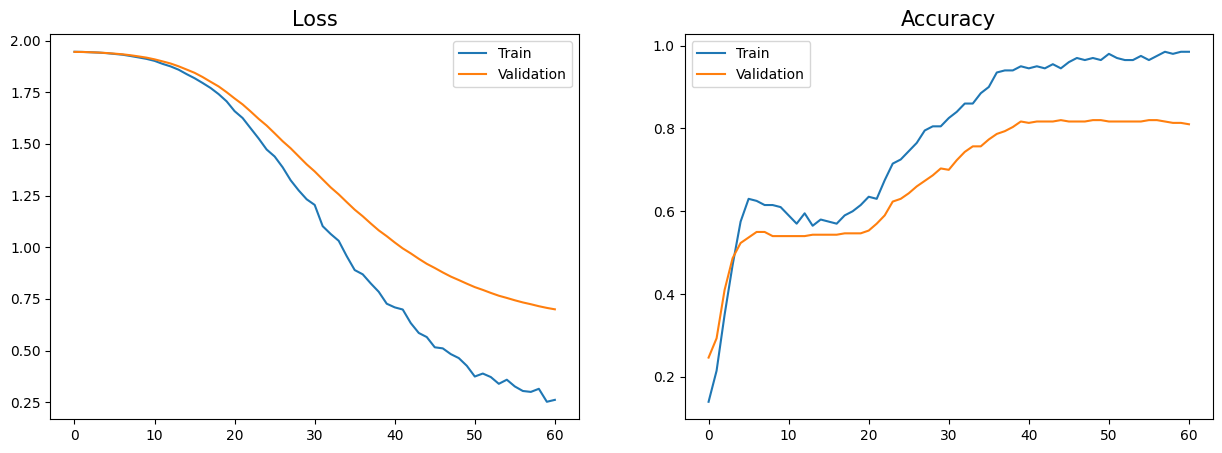

In [20]:

n_labels = labels.max().item() + 1  # 分类个数 7
n_features = features.shape[1]  # 节点个数 1433
print(n_labels, n_features)

# model = GAT(n_features, n_labels, 16, 0.1, 8).to(device)
model = GAT(n_features, n_labels, 8, 0.1, 2).to(device)


optimizer = Ranger(model.parameters())

# 训练模型
epochs = 3000

print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]
    if (i + 1) % print_steps == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]
        print(f'{i + 1:6d}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}' +
              f', val_loss={vl:.4f}, val_acc={va:.4f}')

# 输出最终结果
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
print(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
print(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')
print(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')

# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
for ax, t in zip(axes, ['Loss', 'Accuracy']): ax.legend(), ax.set_title(t, size=15)


In [21]:

# 输出模型预测结果
output = model(features, adj)

samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v: k for k, v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
print(df)


                     Real                    Pred
0   Probabilistic_Methods                  Theory
1              Case_Based              Case_Based
2  Reinforcement_Learning  Reinforcement_Learning
3                  Theory                  Theory
4      Genetic_Algorithms      Genetic_Algorithms
5                  Theory                  Theory
6      Genetic_Algorithms      Genetic_Algorithms
7         Neural_Networks         Neural_Networks
8              Case_Based              Case_Based
9  Reinforcement_Learning  Reinforcement_Learning
